# Example 02 - Sig53 Classifier
This notebook walks through a simple example of how to use the clean Sig53 dataset, load a pre-trained supported model, and evaluate the trained network's performance. Note that the experiment and the results herein are not to be interpreted with any significant value but rather serve simply as a practical example of how the `torchsig` dataset and tools can be used and integrated within a typical [PyTorch](https://pytorch.org/) and/or [PyTorch Lightning](https://www.pytorchlightning.ai/) workflow.

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit. An additional import from the `cm_plotter.py` helper script is also done here to retrieve a function to streamline plotting of confusion matrices.

In [2]:
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import torchsig
from torchsig.datasets.sig53 import Sig53
import torchsig.transforms as ST

from cm_plotter import plot_confusion_matrix

----
### Instantiate Sig53 Dataset
Here, we instantiate the Sig53 clean training dataset and the Sig53 clean validation dataset. We demonstrate how to compose multiple TorchSig transforms together, using a data impairment with a random phase shift that uniformly samples a phase offset between -1 pi and +1 pi. The next transform normalizes the complex tensor, and the final transform converts the complex data to a real-valued tensor with the real and imaginary parts as two channels. We additionally provide a target transform that maps the `SignalDescription` objects, that are part of `SignalData` objects, to a desired format for the model we will train. In this case, we use the `DescToClassIndex` target transform to map class names to their indices within an ordered class list. Finally, we sample from our datasets and print details in order to confirm functionality.

For more details on the Sig53 dataset instantiations, please see the Sig53 example notebook.

In [2]:
# Specify Sig53 Options
root = 'sig53'
train = False
impaired = False
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

# Instantiate the Sig53 Clean Training Dataset
sig53_clean_train = Sig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the Sig53 Clean Validation Dataset
train = False
sig53_clean_val = Sig53(
    root=root, 
    train=train, 
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(sig53_clean_train))
data, label = sig53_clean_train[idx]
print("Dataset length: {}".format(len(sig53_clean_train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

Existing data found, skipping data generation
Existing data found, skipping data generation
Dataset length: 106000
Data shape: (2, 4096)
Label Index: 4
Label Class: qpsk


----
### Format Dataset for Training
Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

In [ ]:
# Create dataloaders
train_dataloader = DataLoader(
    dataset=sig53_clean_train,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

----
### Instantiate Supported TorchSig Model
Below, we load a pretrained EfficientNet-B4 model, and then conform it to a PyTorch LightningModule for training.

In [ ]:
model = torchsig.models.efficientnet_b4(
    pretrained=True,
    path="efficientnet_b4.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
class ExampleNetwork(LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleNetwork, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader
        
        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size
        
    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        return self.data_loader
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        loss = F.cross_entropy(self(x.float()), y)
        return {'loss':loss}
    
    def val_dataloader(self):
        return self.val_data_loader
    
    def validation_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        val_loss = F.cross_entropy(self(x.float()), y)
        return {'val_loss': val_loss}
    
    def validation_epoch_end(self, outputs):
        val_loss_mean = sum([o['val_loss'] for o in outputs]) / len(outputs)
        self.log('val_loss', val_loss_mean, prog_bar=True)
        
example_model = ExampleNetwork(model, train_dataloader, val_dataloader)

----
### Train the Model
To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.

In [ ]:
# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

# Create and fit trainer
epochs = 25
trainer = Trainer(max_epochs=epochs, callbacks=checkpoint_callback, gpus=1)
trainer.fit(example_model)

----
### Evaluate the Trained Model
After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.

In [8]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint['state_dict'])
example_model = example_model.eval()

In [15]:
# Infer results over validation set
num_test_examples = len(sig53_clean_val)
num_classes = len(list(Sig53._idx_to_name_dict.values()))
y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = sig53_clean_val[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|██████████| 1060/1060 [00:32<00:00, 32.84it/s]


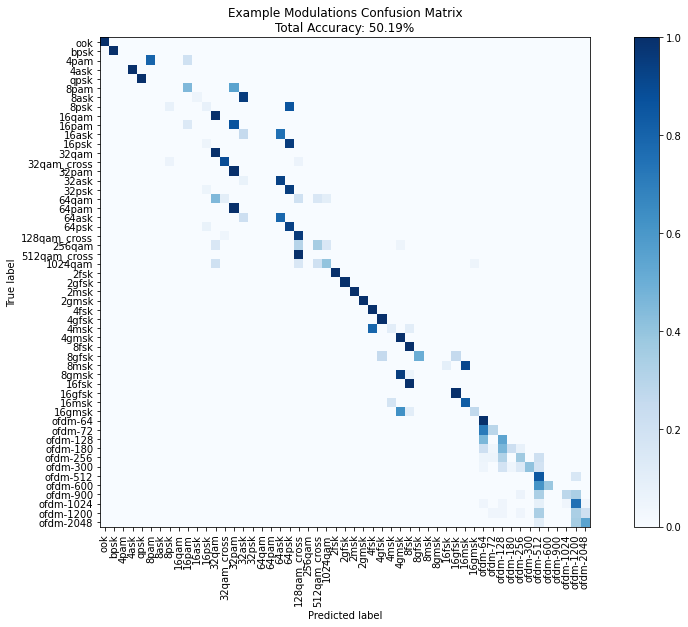

In [21]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_preds))